# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE =1024# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["tau21j1"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 732 batches of 1024 samples each, total 749568 samples
Testset consists of 244 batches of 1024 samples each, total 249856 samples


20

In [12]:
X_train

array([[ 0.45848095],
       [ 0.2181058 ],
       [ 0.01459885],
       ...,
       [-0.13662153],
       [-0.53161925],
       [-0.4444012 ]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['tau21j1'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [03:53<6:26:56, 23.45s/it]


Epoch 10:

Generator training loss: -0.05980997144809512
Discriminator training loss: 0.41998348819916365

Generator validation loss: -0.22778915943669492
Discriminator validation loss: 0.4917503588023733


  2%|█▌                                                                            | 20/1000 [07:47<6:24:21, 23.53s/it]


Epoch 20:

Generator training loss: -0.050607591312088564
Discriminator training loss: 0.17135803385795464

Generator validation loss: -0.6724639759689081
Discriminator validation loss: 0.3959794464658518


  3%|██▎                                                                           | 30/1000 [11:42<6:20:39, 23.55s/it]


Epoch 30:

Generator training loss: 0.2967901497142888
Discriminator training loss: -0.012084974851238203

Generator validation loss: -0.41429607790024553
Discriminator validation loss: -0.0067689350413036396


  4%|███                                                                           | 40/1000 [15:38<6:17:10, 23.57s/it]


Epoch 40:

Generator training loss: 0.7942771972691427
Discriminator training loss: -0.005579277333930545

Generator validation loss: 0.05004124479276723
Discriminator validation loss: 0.004767565872781666


  5%|███▉                                                                          | 50/1000 [19:34<6:13:07, 23.57s/it]


Epoch 50:

Generator training loss: 0.6088715677297181
Discriminator training loss: 0.017076775507163796

Generator validation loss: -0.05399623452151408
Discriminator validation loss: -0.00993449962888768


  6%|████▋                                                                         | 60/1000 [23:32<6:10:51, 23.67s/it]


Epoch 60:

Generator training loss: 0.4199591849019619
Discriminator training loss: 0.008765571888192217

Generator validation loss: -0.29044523138980394
Discriminator validation loss: 0.00448005443611125


  7%|█████▍                                                                        | 70/1000 [27:28<6:04:49, 23.54s/it]


Epoch 70:

Generator training loss: 0.42747980545534464
Discriminator training loss: 0.016224146694973265

Generator validation loss: -0.37733135799892614
Discriminator validation loss: 0.025845523050624937


  8%|██████▏                                                                       | 80/1000 [31:24<6:02:49, 23.66s/it]


Epoch 80:

Generator training loss: 0.3137983028220949
Discriminator training loss: 0.03452526180219357

Generator validation loss: -0.5542114061898873
Discriminator validation loss: -0.021138571705988828


  9%|███████                                                                       | 90/1000 [35:19<5:56:22, 23.50s/it]


Epoch 90:

Generator training loss: 0.45141824428501026
Discriminator training loss: 0.013673788594346637

Generator validation loss: -0.24848587963669028
Discriminator validation loss: 0.007826404715220246


 10%|███████▋                                                                      | 99/1000 [38:51<5:51:58, 23.44s/it]


Epoch 100:

Generator training loss: 0.6719299206316797
Discriminator training loss: -0.005387697089650341

Generator validation loss: 0.058614402948344344
Discriminator validation loss: -0.006498254182513877

Epoch 100:


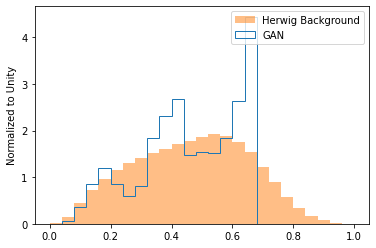

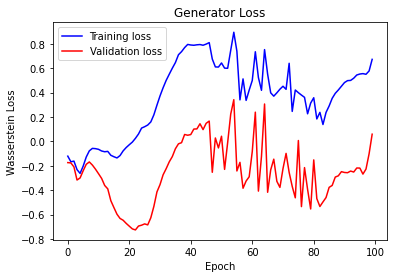

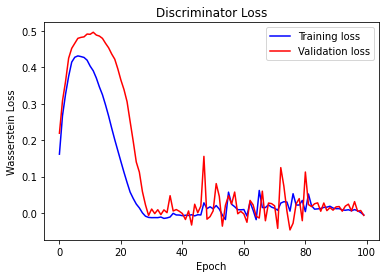

 11%|████████▍                                                                    | 110/1000 [43:09<5:48:13, 23.48s/it]


Epoch 110:

Generator training loss: 0.2682819336632399
Discriminator training loss: 0.026841220427188412

Generator validation loss: -0.5661310082087752
Discriminator validation loss: -0.003542371210761437


 12%|█████████▏                                                                   | 120/1000 [47:04<5:44:01, 23.46s/it]


Epoch 120:

Generator training loss: 0.35006675602552667
Discriminator training loss: 0.005364566735481842

Generator validation loss: -0.3623457415426364
Discriminator validation loss: 0.045643358232527895


 13%|██████████                                                                   | 130/1000 [50:59<5:40:35, 23.49s/it]


Epoch 130:

Generator training loss: 0.23025138435956558
Discriminator training loss: 0.01815417891475938

Generator validation loss: -0.5439238262469651
Discriminator validation loss: -0.012382799519758412


 14%|██████████▊                                                                  | 140/1000 [54:55<5:38:01, 23.58s/it]


Epoch 140:

Generator training loss: 0.2985497473489717
Discriminator training loss: 0.009274203594192886

Generator validation loss: -0.5096109938181814
Discriminator validation loss: 0.027554377342372004


 15%|███████████▌                                                                 | 150/1000 [58:51<5:35:04, 23.65s/it]


Epoch 150:

Generator training loss: 0.39896100560009806
Discriminator training loss: 0.006122752992303733

Generator validation loss: -0.4435994362489122
Discriminator validation loss: 0.00976015296104468


 16%|████████████                                                               | 160/1000 [1:02:48<5:33:15, 23.80s/it]


Epoch 160:

Generator training loss: 0.32205150072854727
Discriminator training loss: 0.005231116271601711

Generator validation loss: -0.6129131727531308
Discriminator validation loss: 0.006388382428444036


 17%|████████████▊                                                              | 170/1000 [1:06:45<5:26:20, 23.59s/it]


Epoch 170:

Generator training loss: 0.4723974607599889
Discriminator training loss: 0.0120761284277668

Generator validation loss: -0.43010292458729665
Discriminator validation loss: 0.0699695375515148


 18%|█████████████▌                                                             | 180/1000 [1:10:40<5:20:57, 23.48s/it]


Epoch 180:

Generator training loss: 0.5382230514711369
Discriminator training loss: 0.017586282463131393

Generator validation loss: -0.19785363721798677
Discriminator validation loss: -0.010979112412314862


 19%|██████████████▎                                                            | 190/1000 [1:14:36<5:18:37, 23.60s/it]


Epoch 190:

Generator training loss: 0.6006523746121777
Discriminator training loss: 0.003125494589727427

Generator validation loss: -0.2463189557072569
Discriminator validation loss: 0.034275313552273874


 20%|██████████████▉                                                            | 199/1000 [1:18:08<5:14:26, 23.55s/it]


Epoch 200:

Generator training loss: 0.5962582742744457
Discriminator training loss: 0.003783055771110596

Generator validation loss: -0.23709136021674657
Discriminator validation loss: -0.01207877112595225

Epoch 200:


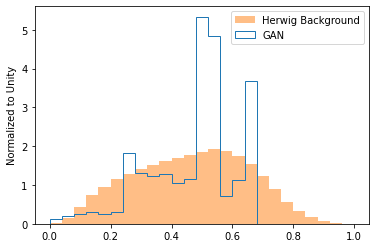

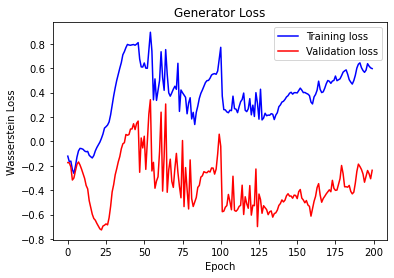

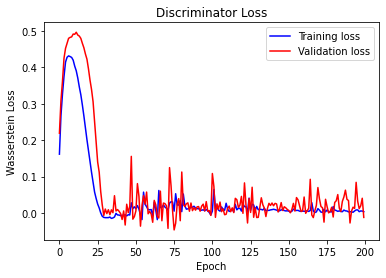

 21%|███████████████▊                                                           | 210/1000 [1:22:28<5:10:40, 23.60s/it]


Epoch 210:

Generator training loss: 0.5732558094412903
Discriminator training loss: 0.003993922194973005

Generator validation loss: -0.24975179386187774
Discriminator validation loss: -0.001039253121786312


 22%|████████████████▌                                                          | 220/1000 [1:26:24<5:07:23, 23.65s/it]


Epoch 220:

Generator training loss: 0.5099837483196962
Discriminator training loss: 0.0037776913040655073

Generator validation loss: -0.30199154234323344
Discriminator validation loss: 0.02882301490028679


 23%|█████████████████▎                                                         | 230/1000 [1:30:20<5:01:51, 23.52s/it]


Epoch 230:

Generator training loss: 0.4309822279410284
Discriminator training loss: 0.004865570434558918

Generator validation loss: -0.43484954230609485
Discriminator validation loss: 0.01498486270638303


 24%|██████████████████                                                         | 240/1000 [1:34:17<5:00:47, 23.75s/it]


Epoch 240:

Generator training loss: 0.4578657872934159
Discriminator training loss: 0.002116725577215732

Generator validation loss: -0.43129600523436656
Discriminator validation loss: 0.01997351198558329


 25%|██████████████████▊                                                        | 250/1000 [1:38:15<4:56:44, 23.74s/it]


Epoch 250:

Generator training loss: 0.3709231275108343
Discriminator training loss: 0.002356956597470314

Generator validation loss: -0.41763064436248093
Discriminator validation loss: 0.006457433313013009


 26%|███████████████████▌                                                       | 260/1000 [1:42:11<4:52:01, 23.68s/it]


Epoch 260:

Generator training loss: 0.4219036924708736
Discriminator training loss: 0.004096060731171747

Generator validation loss: -0.367252776246579
Discriminator validation loss: 0.0013929570833155235


 27%|████████████████████▎                                                      | 270/1000 [1:46:08<4:47:07, 23.60s/it]


Epoch 270:

Generator training loss: 0.37496256294960534
Discriminator training loss: 0.0048699538248513675

Generator validation loss: -0.5378399283670988
Discriminator validation loss: 0.02692711235169077


 28%|█████████████████████                                                      | 280/1000 [1:50:06<4:47:30, 23.96s/it]


Epoch 280:

Generator training loss: 0.3686815339847992
Discriminator training loss: 0.002663188418383505

Generator validation loss: -0.4660038515681126
Discriminator validation loss: 0.01746195530561591


 29%|█████████████████████▊                                                     | 290/1000 [1:54:02<4:39:25, 23.61s/it]


Epoch 290:

Generator training loss: 0.34115485266828144
Discriminator training loss: 0.0060687492333277495

Generator validation loss: -0.5073006332653468
Discriminator validation loss: -0.024015325442439357


 30%|██████████████████████▍                                                    | 299/1000 [1:57:35<4:37:05, 23.72s/it]


Epoch 300:

Generator training loss: 0.26599982254654986
Discriminator training loss: 0.0034280002435748505

Generator validation loss: -0.56639179733933
Discriminator validation loss: 0.006985157112064714

Epoch 300:


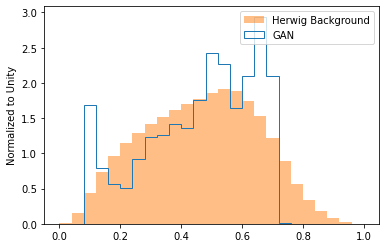

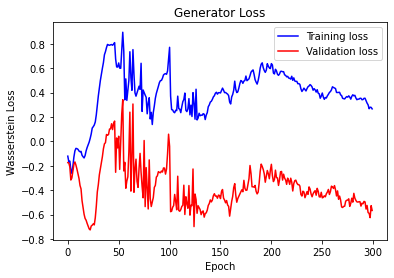

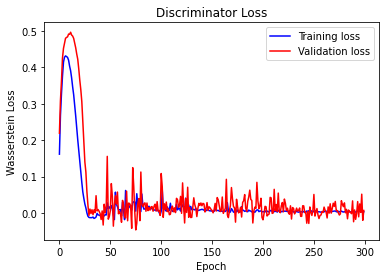

 31%|███████████████████████▎                                                   | 310/1000 [2:01:56<4:33:12, 23.76s/it]


Epoch 310:

Generator training loss: 0.24170511701434363
Discriminator training loss: 0.003533118048139567

Generator validation loss: -0.6098009963504604
Discriminator validation loss: -0.0001873737923919269


 32%|████████████████████████                                                   | 320/1000 [2:05:51<4:27:17, 23.58s/it]


Epoch 320:

Generator training loss: 0.32125353349036856
Discriminator training loss: 0.0045235344147289145

Generator validation loss: -0.5152786376534916
Discriminator validation loss: -0.01354292010555433


 33%|████████████████████████▊                                                  | 330/1000 [2:09:48<4:23:35, 23.60s/it]


Epoch 330:

Generator training loss: 0.31918435063355605
Discriminator training loss: 0.004060777169559184

Generator validation loss: -0.5088093632557353
Discriminator validation loss: 0.031968019536791084


 34%|█████████████████████████▌                                                 | 340/1000 [2:13:46<4:21:44, 23.80s/it]


Epoch 340:

Generator training loss: 0.21076068351340424
Discriminator training loss: 0.0056182550419037304

Generator validation loss: -0.6208853369853535
Discriminator validation loss: -0.008106838260841943


 35%|██████████████████████████▎                                                | 350/1000 [2:17:42<4:16:12, 23.65s/it]


Epoch 350:

Generator training loss: 0.17805967501318845
Discriminator training loss: 0.008346072680624126

Generator validation loss: -0.6367498262495291
Discriminator validation loss: -0.0019320784247342925


 36%|███████████████████████████                                                | 360/1000 [2:21:39<4:13:11, 23.74s/it]


Epoch 360:

Generator training loss: 0.13206934333839987
Discriminator training loss: 0.010532854338297476

Generator validation loss: -0.7469264718352772
Discriminator validation loss: 0.07032155726471397


 37%|███████████████████████████▊                                               | 370/1000 [2:25:36<4:08:15, 23.64s/it]


Epoch 370:

Generator training loss: 0.009420806233188432
Discriminator training loss: 0.008205555718122327

Generator validation loss: -0.8026729673147202
Discriminator validation loss: 0.012659462378503464


 38%|████████████████████████████▌                                              | 380/1000 [2:29:32<4:04:18, 23.64s/it]


Epoch 380:

Generator training loss: 0.08488549613947292
Discriminator training loss: 0.0047229565584430665

Generator validation loss: -0.7239251940465364
Discriminator validation loss: -0.001567422765398734


 39%|█████████████████████████████▎                                             | 390/1000 [2:33:29<4:01:28, 23.75s/it]


Epoch 390:

Generator training loss: 0.17410292596011703
Discriminator training loss: 0.003013179706649084

Generator validation loss: -0.7153286462435957
Discriminator validation loss: 0.015373381914749367


 40%|█████████████████████████████▉                                             | 399/1000 [2:37:02<3:56:15, 23.59s/it]


Epoch 400:

Generator training loss: 0.13405954859555377
Discriminator training loss: 0.00817393530195177

Generator validation loss: -0.6913414121162696
Discriminator validation loss: 0.03343391539404917

Epoch 400:


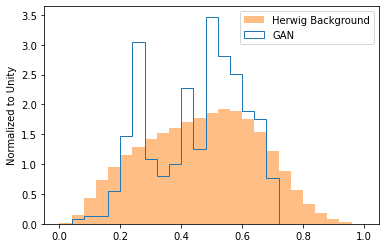

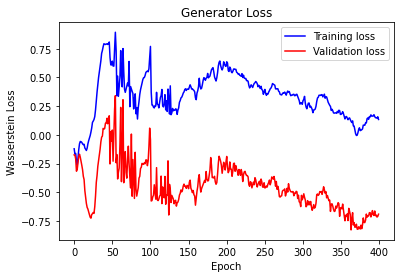

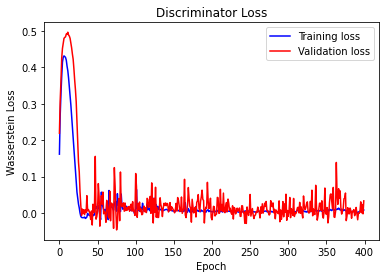

 41%|██████████████████████████████▋                                            | 410/1000 [2:41:23<3:53:22, 23.73s/it]


Epoch 410:

Generator training loss: 0.02565459280686397
Discriminator training loss: 0.0031849581567272613

Generator validation loss: -0.8895091656290117
Discriminator validation loss: 0.011062938264703767


 42%|███████████████████████████████▌                                           | 420/1000 [2:45:19<3:48:14, 23.61s/it]


Epoch 420:

Generator training loss: 0.06408646460870647
Discriminator training loss: 0.0017873727024255812

Generator validation loss: -0.8428307805882126
Discriminator validation loss: 0.010975890151548512


 43%|████████████████████████████████▎                                          | 430/1000 [2:49:15<3:43:36, 23.54s/it]


Epoch 430:

Generator training loss: 0.006868537705451444
Discriminator training loss: 0.005372756870674692

Generator validation loss: -0.9120072072646657
Discriminator validation loss: 0.051945061733007246


 44%|█████████████████████████████████                                          | 440/1000 [2:53:12<3:41:22, 23.72s/it]


Epoch 440:

Generator training loss: -0.015587368492441649
Discriminator training loss: 0.004310549751865243

Generator validation loss: -0.8980342066678845
Discriminator validation loss: -0.011317362544030433


 45%|█████████████████████████████████▊                                         | 450/1000 [2:57:09<3:36:38, 23.63s/it]


Epoch 450:

Generator training loss: -0.10454567843511232
Discriminator training loss: 0.003795322124931305

Generator validation loss: -0.9660821456889637
Discriminator validation loss: 0.000317818713975597


 46%|██████████████████████████████████▌                                        | 460/1000 [3:01:05<3:32:11, 23.58s/it]


Epoch 460:

Generator training loss: -0.15411424649818267
Discriminator training loss: 0.007699747446161785

Generator validation loss: -0.9903991388492897
Discriminator validation loss: 0.010163822502721307


 47%|███████████████████████████████████▎                                       | 470/1000 [3:05:03<3:29:07, 23.67s/it]


Epoch 470:

Generator training loss: -0.2398447075380328
Discriminator training loss: 0.005758960234867674

Generator validation loss: -1.1123354283512616
Discriminator validation loss: -0.004789623147264108


 48%|████████████████████████████████████                                       | 480/1000 [3:08:59<3:24:01, 23.54s/it]


Epoch 480:

Generator training loss: -0.23326077832855652
Discriminator training loss: 0.013207970077236808

Generator validation loss: -1.0029246777784628
Discriminator validation loss: -0.019475294306652895


 49%|████████████████████████████████████▊                                      | 490/1000 [3:12:54<3:19:23, 23.46s/it]


Epoch 490:

Generator training loss: -0.28773113242426857
Discriminator training loss: 0.007674342509892851

Generator validation loss: -1.1416094874749418
Discriminator validation loss: 0.010742537028117574


 50%|█████████████████████████████████████▍                                     | 499/1000 [3:16:26<3:16:17, 23.51s/it]


Epoch 500:

Generator training loss: -0.24621474997349124
Discriminator training loss: 0.005312629181748467

Generator validation loss: -1.118006855249405
Discriminator validation loss: -0.006661589084316921

Epoch 500:


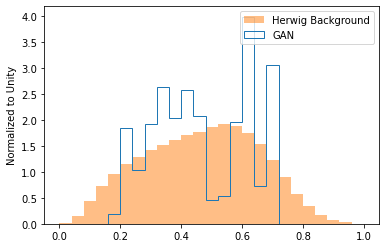

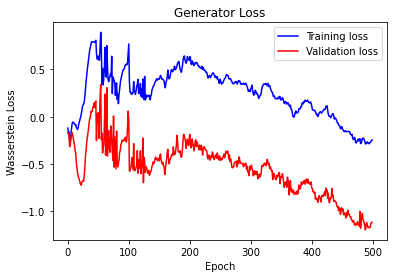

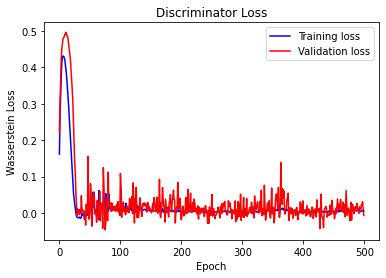

 51%|██████████████████████████████████████▎                                    | 510/1000 [3:20:45<3:12:52, 23.62s/it]


Epoch 510:

Generator training loss: -0.31398604964949395
Discriminator training loss: 0.0060768936312516645

Generator validation loss: -1.1884698037241326
Discriminator validation loss: 0.010779186035834441


 52%|███████████████████████████████████████                                    | 520/1000 [3:24:41<3:09:03, 23.63s/it]


Epoch 520:

Generator training loss: -0.4302430562878567
Discriminator training loss: 0.0062203016456244325

Generator validation loss: -1.2946147459452269
Discriminator validation loss: 0.004554460384094797


 53%|███████████████████████████████████████▊                                   | 530/1000 [3:28:36<3:04:25, 23.54s/it]


Epoch 530:

Generator training loss: -0.5182554988506062
Discriminator training loss: 0.013655415085687095

Generator validation loss: -1.4176613888779626
Discriminator validation loss: 0.013339416176170401


 54%|████████████████████████████████████████▌                                  | 540/1000 [3:32:32<3:00:08, 23.50s/it]


Epoch 540:

Generator training loss: -0.602668115227926
Discriminator training loss: 0.004356621115913369

Generator validation loss: -1.506576631401406
Discriminator validation loss: 0.011388569322990092


 55%|█████████████████████████████████████████▎                                 | 550/1000 [3:36:28<2:57:16, 23.64s/it]


Epoch 550:

Generator training loss: -0.6672176474430522
Discriminator training loss: 0.008951598092985751

Generator validation loss: -1.5709623469681036
Discriminator validation loss: 0.01456577239508481


 56%|██████████████████████████████████████████                                 | 560/1000 [3:40:23<2:52:33, 23.53s/it]


Epoch 560:

Generator training loss: -0.7112475608378812
Discriminator training loss: 0.00568433254879072

Generator validation loss: -1.595505924009886
Discriminator validation loss: -0.013922996751567612


 57%|██████████████████████████████████████████▋                                | 570/1000 [3:44:18<2:48:04, 23.45s/it]


Epoch 570:

Generator training loss: -0.7634853541525335
Discriminator training loss: 0.00412312859077192

Generator validation loss: -1.7180526955205886
Discriminator validation loss: 0.01612714710951922


 58%|███████████████████████████████████████████▌                               | 580/1000 [3:48:13<2:44:34, 23.51s/it]


Epoch 580:

Generator training loss: -0.8248090546964948
Discriminator training loss: 0.002668494350542482

Generator validation loss: -1.7574501902353568
Discriminator validation loss: -0.000918219841326793


 59%|████████████████████████████████████████████▎                              | 590/1000 [3:52:08<2:41:34, 23.65s/it]


Epoch 590:

Generator training loss: -0.8298262107730563
Discriminator training loss: 0.006017892595752175

Generator validation loss: -1.7770257963508855
Discriminator validation loss: 0.012512290694415198


 60%|████████████████████████████████████████████▉                              | 599/1000 [3:55:39<2:36:59, 23.49s/it]


Epoch 600:

Generator training loss: -0.7801497171485359
Discriminator training loss: 0.00814747563040651

Generator validation loss: -1.7189471350341547
Discriminator validation loss: 0.00743045618797683

Epoch 600:


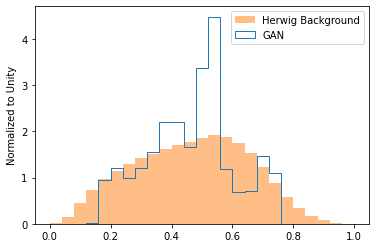

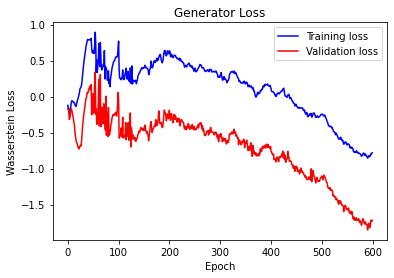

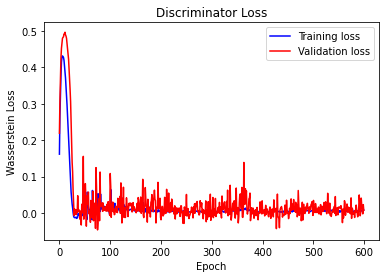

 61%|█████████████████████████████████████████████▊                             | 610/1000 [3:59:58<2:33:11, 23.57s/it]


Epoch 610:

Generator training loss: -0.8434914507663966
Discriminator training loss: 0.0019926989859627587

Generator validation loss: -1.8094620885419064
Discriminator validation loss: 0.009832858951190022


 61%|███████████████████████████████████████████▌                           | 613/1000 [7:17:30<268:29:21, 2497.57s/it]

In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z